In [1]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit IPython integration
from rdkit.Chem import PandasTools
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [3]:
# read data

data = pd.DataFrame()

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    fingerprints = []
    smiles = []
    groups = []

    for frag in suppl:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        s = Chem.MolToSmiles(fixed_frag)
        fragments.append(fixed_frag)
        # fingerprint of fragment
        fingerprints.append(rdkit_gen.GetFingerprint(fixed_frag))
        # smiles for comparing fragments
        smiles.append(s)
        # kinase groups
        groups.append(frag.GetProp('group'))
      
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['fingerprint'] = fingerprints
    df['subpocket'] = subpocket
    df['group'] = groups
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7201, 5)

In [4]:
n_frags_per_sp = {}
for sp in subpockets:
    n_frags_per_sp[sp] = data[data.subpocket == sp].shape[0]
n_frags_per_sp

{'AP': 2561, 'FP': 1866, 'SE': 1560, 'GA': 1024, 'B1': 98, 'B2': 92}

In [5]:
groups = data.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

In [6]:
n_frags_per_group = {}
for g in groups:
    n_frags_per_group[g] = data[data.group == g].shape[0]
n_frags_per_group

{'Other': 766,
 'TK': 2029,
 'TKL': 519,
 'AGC': 304,
 'CMGC': 2241,
 'CAMK': 894,
 'CK1': 135,
 'STE': 313}

1. Group all fragments by kinase group
2. Deduplicate within kinase group and subpocket
3. Calculate similarity within kinase groups and subpockets

In [55]:
sim_data = {}

for group in groups:
    
    # get data for this group
    dg = data[data.group==group]
    # deduplicate based on SMILES
    dg = dg.drop_duplicates(['smiles', 'subpocket'])
    
    # calculate similarities within subpockets
    sim_data_group = []
    
    # iterate over subpockets
    for sp in subpockets:
        
        dgsp = dg[dg.subpocket==sp]
        
        # iterate over fragment pairs
        for i, fp1 in enumerate(dgsp.fingerprint):
            for j, fp2 in enumerate(dgsp.fingerprint):
                
                # no self comparisons
                if i != j:

                    sim = DataStructs.FingerprintSimilarity(fp1, fp2) # tanimoto similarity
                    sim_data_group.append(sim)
    
    sim_data[group] = sim_data_group
    

In [56]:
sim_df = pd.DataFrame(columns=['Tanimoto similarity'])
for group in groups:
    df = pd.DataFrame(sim_data[group], columns=['Tanimoto similarity'])
    df['group'] = group
    sim_df = sim_df.append(df, sort=True)

4. Calculate total distribution (across all kinase groups)

In [61]:
def flatten_dict(d):
    
    lst = []
    for key in d:
        lst.extend(d[key])
    return lst

In [62]:
# total distribution of similarities within subpockets (dedup)
df = pd.DataFrame(data=flatten_dict(sim_data), columns=['Tanimoto similarity'])
df['group'] = 'Total'

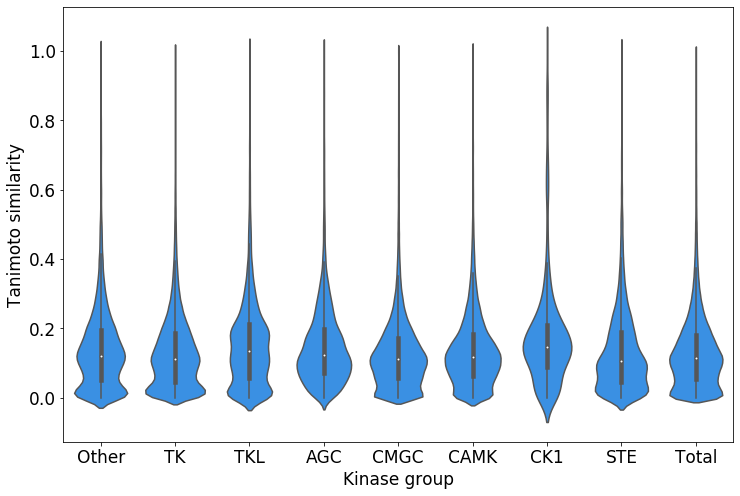

In [64]:
# plot distributions
sim_df = sim_df.append(df) # add total distribution

plt.figure(figsize=(12,8))
ax = sns.violinplot(x='group', y='Tanimoto similarity', data=sim_df, color='dodgerblue')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Tanimoto similarity', fontsize=17)
plt.xlabel('Kinase group', fontsize=17)
plt.savefig('/home/paula/Masterarbeit/manuscript/Figures/fa_sim_intragroup.png', dpi=300)